In [7]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ~/bmi_dynamics_code/

/Users/preeyakhanna/bmi_dynamics_code


In [4]:
from online_analysis import util_fcns, sim_utils

In [47]:
from sklearn.linear_model import LinearRegression

In [49]:
LinearRegression.fit?

<IPython.core.display.Javascript object>


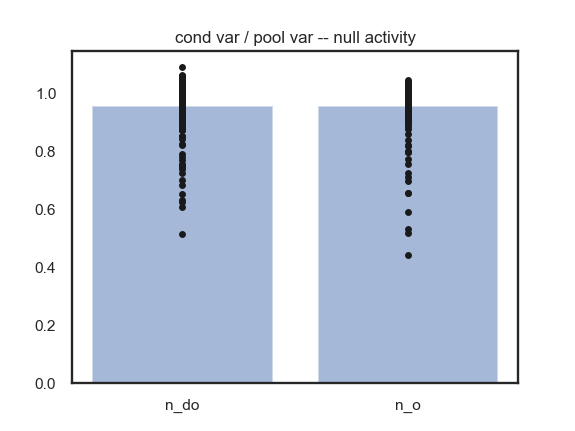

<IPython.core.display.Javascript object>


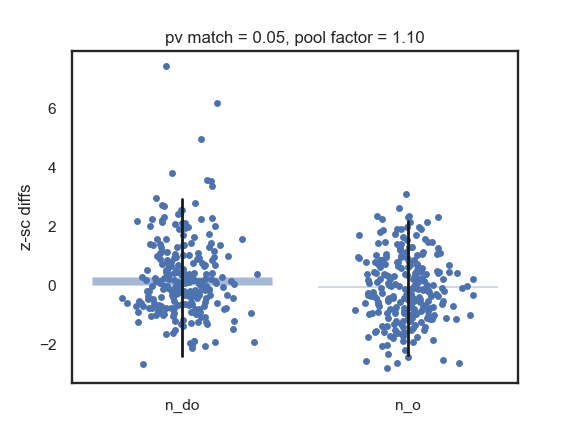

[[ 0.05262659  0.04537925 -0.00946915 -0.00598859 -0.03488345 -0.03914317
  -0.04452513 -0.0980977   0.03686523 -0.06811521 -0.06809136  0.04181099
  -0.01837773  0.03958104  0.03417783  0.01234778  0.01454164 -0.03734813
  -0.07738526  0.06655391  0.03449842 -0.05735192  0.07191174 -0.02705872
  -0.04957577  0.03289089  0.06782069 -0.03505714 -0.08536615  0.17664384
   0.0096917  -0.08046861  0.00901057 -0.04811366  0.00043313  0.01564263
  -0.00033782 -0.0515501   0.00704715 -0.06022748 -0.0006387  -0.06016245]
 [ 0.00735861  0.08267309  0.0386184  -0.0206835   0.05920899 -0.02205639
   0.04001657  0.02428194 -0.00058411 -0.01240686  0.01650139  0.02639651
  -0.01480476 -0.01151922 -0.0270872  -0.01828204 -0.01935922 -0.02202127
   0.06170124 -0.0268403   0.01995853 -0.07959979 -0.08457538  0.06399955
   0.00688026  0.02770729 -0.01168431 -0.06000343  0.07891376  0.07455356
   0.00767897  0.03793119  0.0268807  -0.04283099  0.0496636   0.03414656
  -0.08626745  0.02636076  0.00890165

<IPython.core.display.Javascript object>


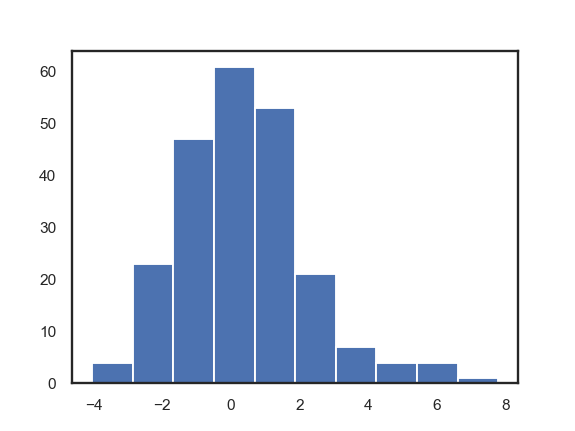

Mean Z_diff: 0.3939


In [86]:
simulation = 'df_lqr_n'
max_pool_factor = 100000.; 

f3, ax3 = plt.subplots()
ax3.set_title('cond var / pool var -- null activity')
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['n_do', 'n_o'])
for pv in [0.05]: 
    for pool_factor in [1.1]: 
        
        f, ax = plt.subplots()
        
        cc = dict()
        shuff = dict()
        
        ### get out data
        cc_v = dict()
        pool_v = dict()
        
        for i_m, model in enumerate(['n_do', 'n_o']): 
            _, com, cond, pot, activity, _, scores = sim_utils.return_lqr_data(model = model, 
                                                                               simulation=simulation, 
                                                                       dyn='null', add_noise_no = False)
            ### Plot scores from linear regression ###
            #ax3.plot(np.zeros((len(scores), )) + i_m, scores, 'k.')
            #ax3.bar(i_m, np.mean(scores), color='b', alpha=.5)
            
            cc_dist, shuff_cc_dist, cc_var, pool_var = sim_utils.get_cond_com_pls_matched_inds(com, cond, 
                                                                    activity, pot, nshuff=50,
                                                                    pv=pv, 
                                                                    min_pool_factor=pool_factor, 
                                                                    max_pool_factor=max_pool_factor,
                                                                    min_commands=15, 
                                                                    max_commands = 10000.)
            
            #### Plot distances #### 
            cc_v[model] = cc_var
            pool_v[model] = pool_var;
            
            print('Model %s: # commands: %d'%(model, len(cc_dist.keys())))
            
            ax = sim_utils.plot2(cc_dist, shuff_cc_dist, i_m, ax)
            
            cc[model] = cc_dist; 
            shuff[model] = shuff_cc_dist;
            
        ### show pairs of command conditions 
        Z_diff = []; rat_diff = []; 
        Z_pairs = []; 
        
        ## choose n_do for keys
        for i_k, k in enumerate(cc['n_do'].keys()): 
            if k in cc['n_o'].keys(): 
                
                mn_ndo = np.mean(shuff['n_do'][k])
                st_ndo = np.std(shuff['n_do'][k])
                z_ndo = (cc['n_do'][k] - mn_ndo) / st_ndo
                
                mn_no = np.mean(shuff['n_o'][k])
                st_no = np.std(shuff['n_o'][k])
                z_no = (cc['n_o'][k] - mn_no) / st_no
            
                ### diff 
                Z_diff.append(z_ndo - z_no)
                Z_pairs.append([z_ndo, z_no])
                
                ### Same 
                rat_ndo = cc_v['n_do'][k] / pool_v['n_do'][k]
                rat_no = cc_v['n_o'][k] / pool_v['n_o'][k]
                rat_diff.append(rat_ndo-rat_no)
            
        ax.set_ylabel('z-sc diffs')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['n_do', 'n_o'])
        ax.set_title('pv match = %.2f, pool factor = %.2f'%(pv, pool_factor))
        
        
        rats = []
        for k in cc_v['n_do'].keys(): 
            if k in cc_v['n_o'].keys(): 
                rat1 = cc_v['n_do'][k] / pool_v['n_do'][k]
                rat2 = cc_v['n_o'][k] / pool_v['n_o'][k]
                rats.append([rat1, rat2])
        rats = np.vstack((rats))
        ax3.plot(np.zeros((rats.shape[0])), rats[:, 0], 'k.')
        ax3.plot(np.zeros((rats.shape[0]))+1, rats[:, 1], 'k.')
        ax3.bar(0, np.mean(rats[:, 0]), color='b', alpha=.5)
        ax3.bar(1, np.mean(rats[:, 1]), color='b', alpha=.5)
        
f2, ax2 = plt.subplots()
ax2.hist(Z_diff)
print('Mean Z_diff: %.4f'%(np.mean(Z_diff)))

In [45]:
Z_pairs = np.vstack((Z_pairs))

In [46]:
scipy.stats.ttest_rel(Z_pairs[:, 0], Z_pairs[:, 1])

Ttest_relResult(statistic=0.2322696574176726, pvalue=0.8165406462194297)

In [82]:
scipy.stats.ttest_rel(rats[:, 0], rats[:, 1])

Ttest_relResult(statistic=0.28666599799117876, pvalue=0.7746330486827615)

<IPython.core.display.Javascript object>


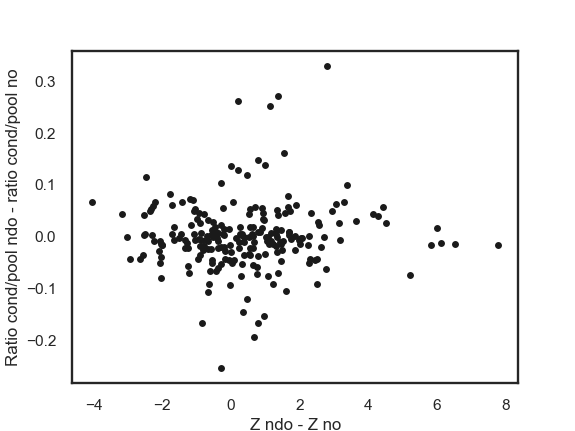

Text(0,0.5,'Ratio cond/pool ndo - ratio cond/pool no')

In [89]:
### z-diff vs. rat-diff :
f, ax = plt.subplots()
ax.plot(Z_diff, rat_diff, 'k.')
ax.set_xlabel('Z ndo - Z no')
ax.set_ylabel('Ratio cond/pool ndo - ratio cond/pool no')

In [ ]:
###

<IPython.core.display.Javascript object>


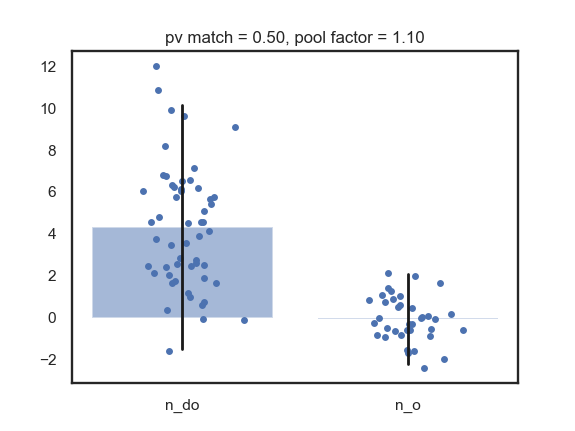

<IPython.core.display.Javascript object>


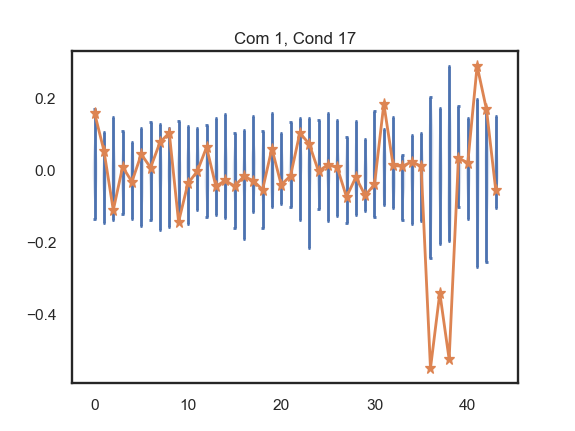

<IPython.core.display.Javascript object>


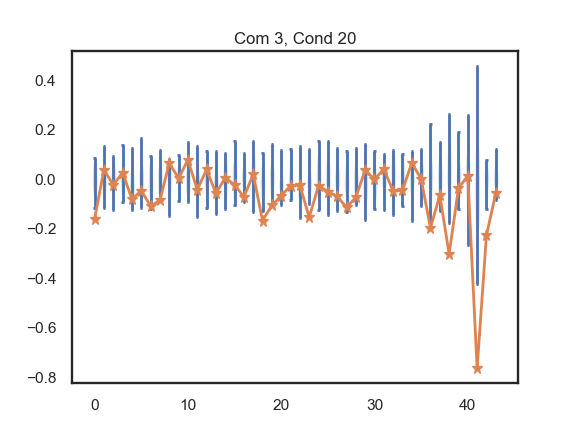

<IPython.core.display.Javascript object>


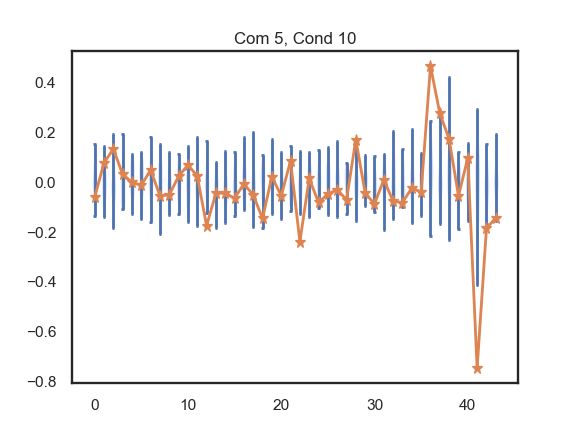

<IPython.core.display.Javascript object>


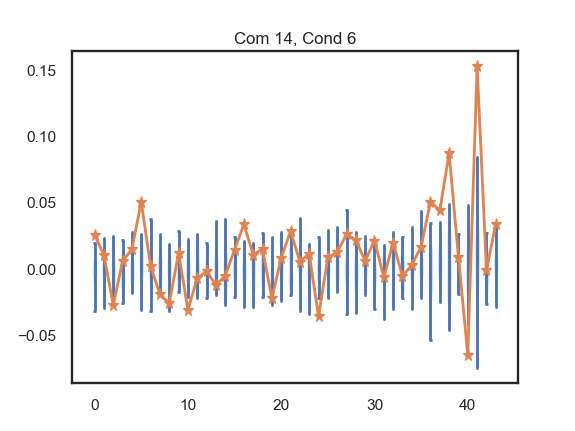

<IPython.core.display.Javascript object>


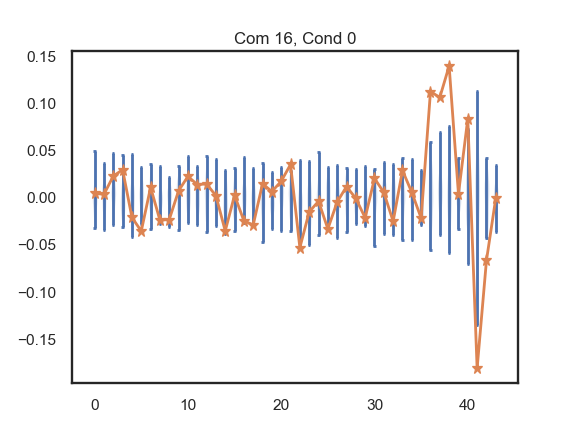

<IPython.core.display.Javascript object>


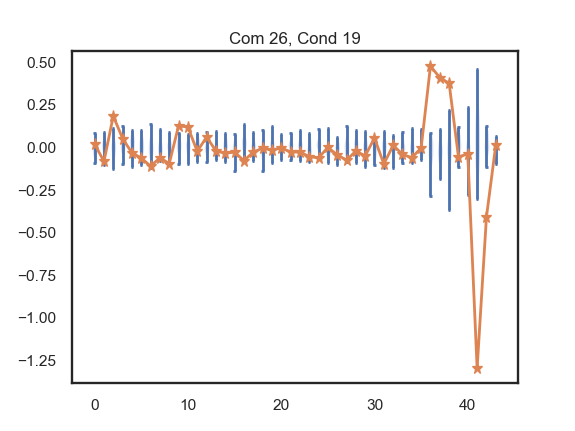

Model n_do: # commands: 54
GT20: (1, 17.0)
GT20: (3, 20.0)
GT20: (14, 6.0)
GT20: (5, 10.0)
GT20: (16, 0.0)
GT20: (26, 19.0)
mn -1.505, max 10.160
Model n_o: # commands: 37
mn -2.217, max 2.088


In [54]:
for pv in [.5]: 
    for pool_factor in [1.1]: 
        
        f, ax = plt.subplots()
        
        ### get out data
        for i_m, model in enumerate(['n_do', 'n_o']): 
            activity, com, cond, pot, null, _ = sim_utils.return_lqr_data(model = model, dyn='full')
            
            cc_dist, shuff_cc_dist = sim_utils.get_cond_com_pls_matched_inds(com, cond, activity, pot, nshuff=50,
                                                                pv=pv, pool_factor=pool_factor, min_commands=15)
            
            print('Model %s: # commands: %d'%(model, len(cc_dist.keys())))
            
            ax = sim_utils.plot2(cc_dist, shuff_cc_dist, i_m, ax)

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['n_do', 'n_o'])
        ax.set_title('pv match = %.2f, pool factor = %.2f'%(pv, pool_factor))

In [68]:
np.allclose?

In [4]:
### Plot out resutsl

In [16]:
####### distributions of true vs shuffle; 

<IPython.core.display.Javascript object>


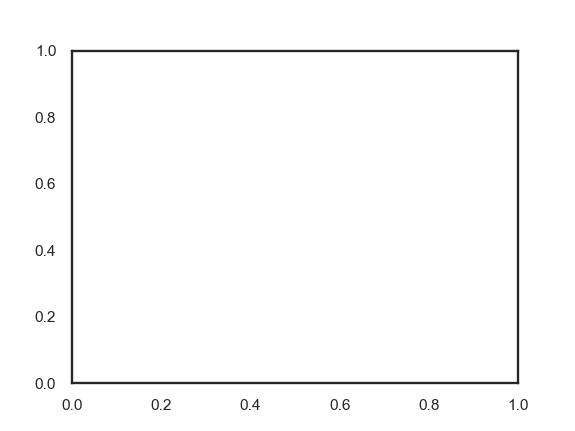

Model n_do: # commands: 160


<IPython.core.display.Javascript object>


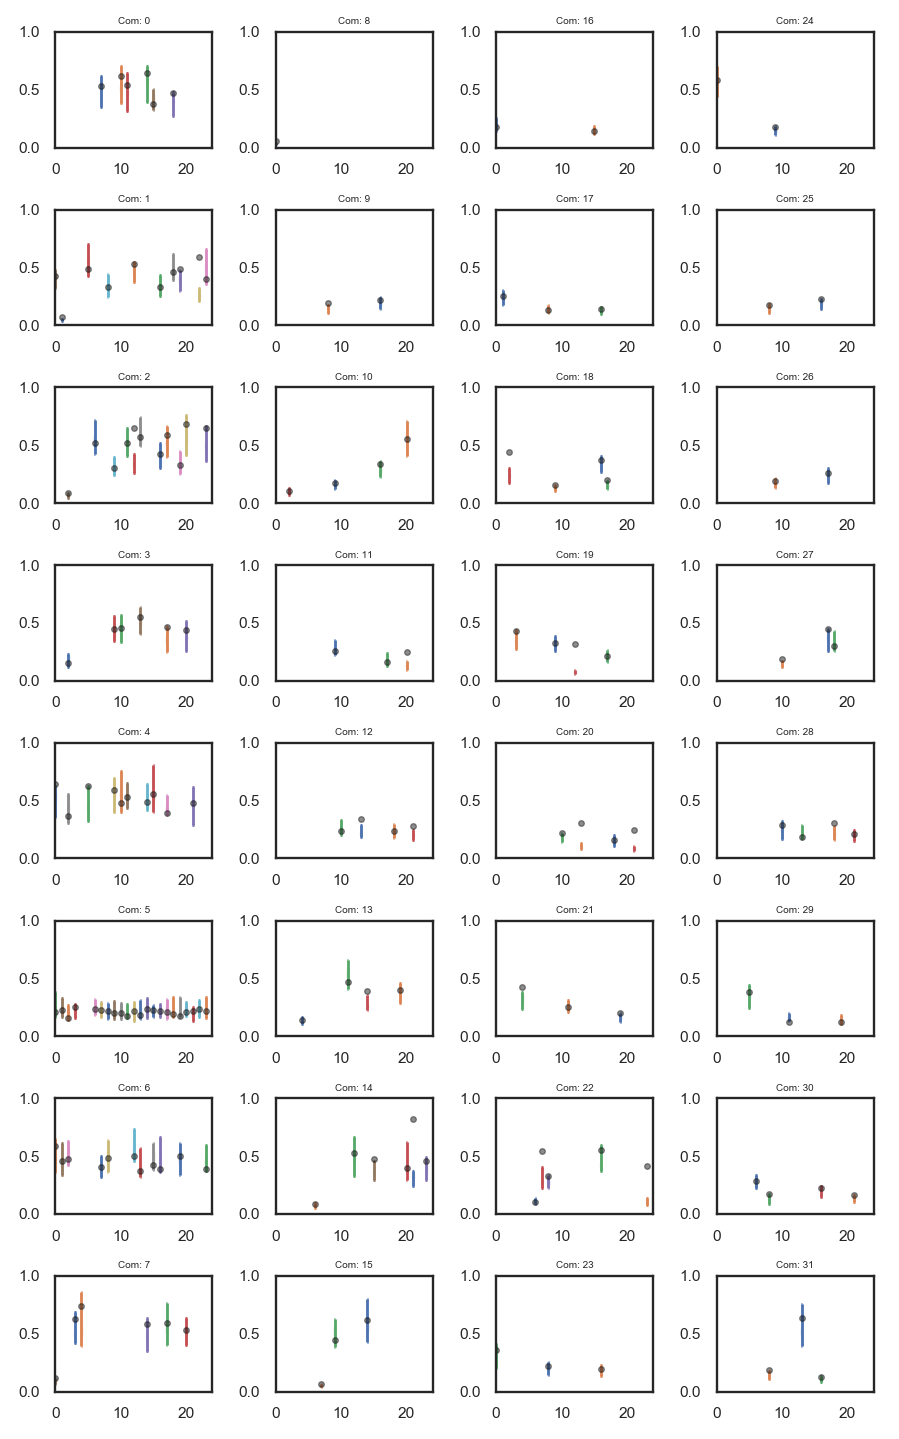

Model n_o: # commands: 157


<IPython.core.display.Javascript object>


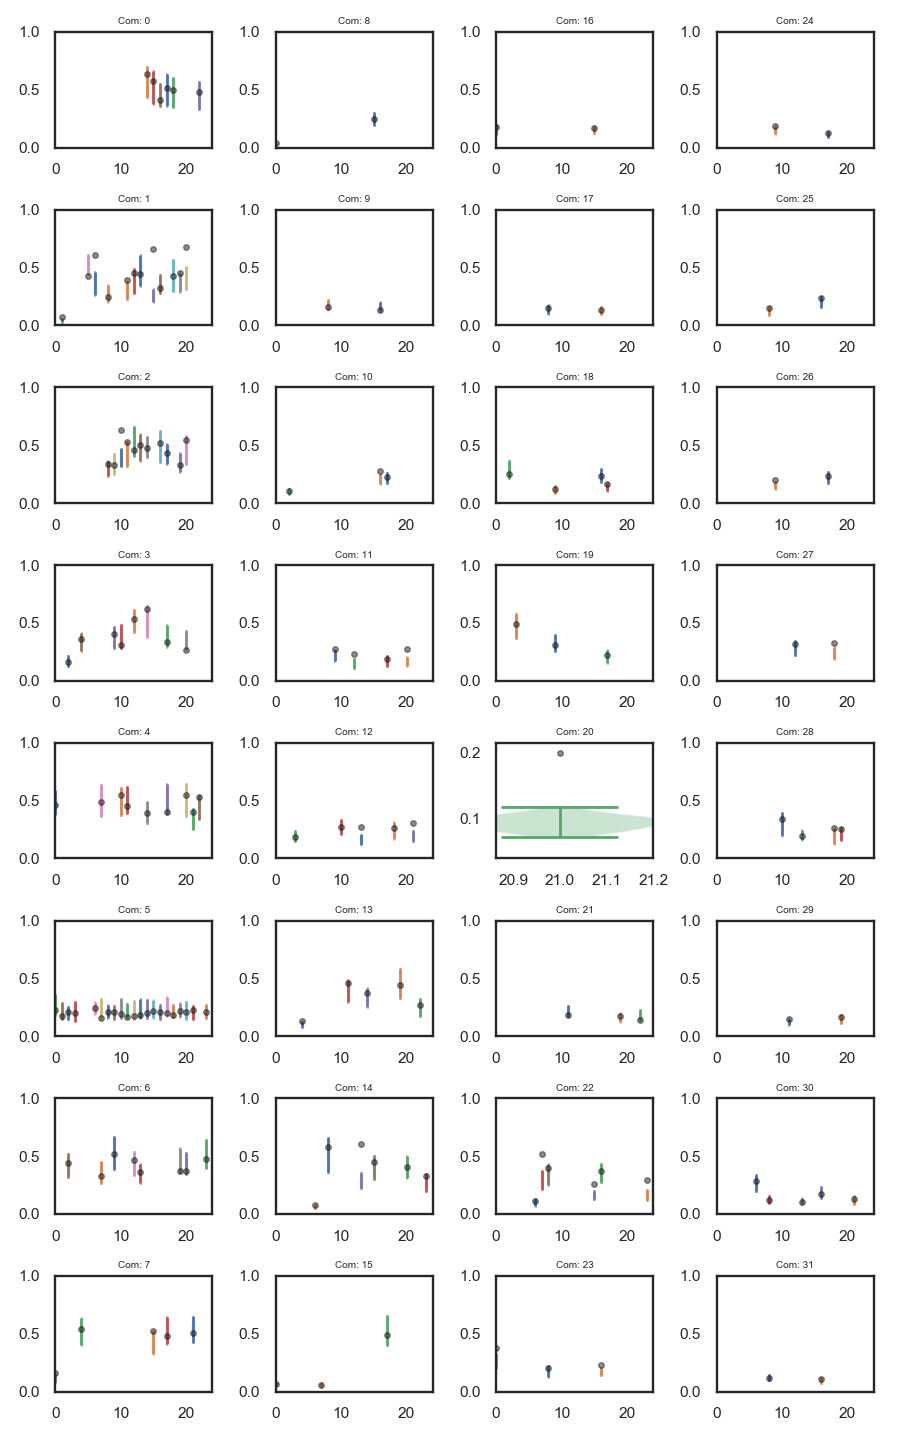

In [27]:
for pv in [.05]:#, .25, .5]: 
    for pool_factor in [1.1]: 
        
        f, ax = plt.subplots()
        
        ### get out data
        for i_m, model in enumerate(['n_do', 'n_o']): 
            act, com, cond, pot, _, _ = sim_utils.return_null_lqr_data(model = model)
            cc_dist, shuff_cc_dist = sim_utils.get_cond_com_pls_matched_inds(com, cond, act, pot, nshuff=50,
                                                                    pv=pv, pool_factor=pool_factor, min_commands=10)
            print('Model %s: # commands: %d'%(model, len(cc_dist.keys())))
            ax = sim_utils.plot(cc_dist, shuff_cc_dist, '')


In [64]:
np.square?

In [65]:
plt.scatter?

[autoreload of online_analysis.sim_utils failed: Traceback (most recent call last):
  File "/Users/preeyakhanna/conda/envs/py27/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "online_analysis/sim_utils.py", line 221
    _, px = scipy.stats.ttest_ind(val[ix0, 0], val[ix1[ix1_keep], 0])
    ^
IndentationError: unexpected indent
]
